# Chest X-Ray Images (Pneumonia)

## 폐렴 진단 프로젝트

In [1]:
import os, re
import random, math
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

## 변수 설정

In [2]:
#데이터 로드할 때 빠르게 로드할 수 있도록하는 설정 변수
AUTOTUNE = tf.data.experimental.AUTOTUNE

#X-RAY 이미지 사이즈 변수
IMAGE_SIZE = [180, 180]

#데이터 경로 변수
ROOT_PATH = os.path.join(os.getenv('HOME'), 'aiffel')
TRAIN_PATH = ROOT_PATH + '/chest_xray/data/train/*/*'
VAL_PATH = ROOT_PATH + '/chest_xray/data/val/*/*'
TEST_PATH = ROOT_PATH + '/chest_xray/data/test/*/*'

#변경 가능한 파라미터
BATCH_SIZE = 16
EPOCHS = 25

print(ROOT_PATH)

/aiffel/aiffel


## 데이터 로드 및 데이터 준비

In [3]:
#데이터 로드
train_filenames = tf.io.gfile.glob(TRAIN_PATH)
test_filenames = tf.io.gfile.glob(TEST_PATH)
val_filenames = tf.io.gfile.glob(VAL_PATH)

print(len(train_filenames))
print(len(test_filenames))
print(len(val_filenames))

5216
624
16


In [4]:
#val 개수가 너무 없기 때문에 train에서 val에 쓰일 데이터를 더 가져옴.
#train 데이터와 validation 데이터를 모두 filenames에 담음.
filenames = tf.io.gfile.glob(TRAIN_PATH)
filenames.extend(tf.io.gfile.glob(VAL_PATH))

#train과 val에 있는 데이터를 모은 다음에 train : val를 80:20으로 분할.
train_size = math.floor(len(filenames)*0.8)
random.seed(1234)
random.shuffle(filenames)
train_filenames = filenames[:train_size]
val_filenames = filenames[train_size:]

print(len(train_filenames))
print(len(val_filenames))

4185
1047


In [5]:
#정상 이미지와 폐렴 이미지의 구분은 파일 경로로 할 수 있음.
print(f'Normal image path\n{filenames[0]}')
print(f'Pneumonia image path\n{filenames[2000]}')

Normal image path
/aiffel/aiffel/chest_xray/data/train/NORMAL/IM-0711-0001.jpeg
Pneumonia image path
/aiffel/aiffel/chest_xray/data/train/PNEUMONIA/person1343_virus_2317.jpeg


In [7]:
#파일 경로에 NORMAL과 PNEUMONIA이 있는지로 
#정상 이미지와 폐렴 이미지 파일을 구별 할 수 있음.

COUNT_NORMAL = len([filename for filename in train_filenames if "NORMAL" in filename])
print(f"Normal images count in training set: {COUNT_NORMAL}")

COUNT_PNEUMONIA = len([filename for filename in train_filenames if "PNEUMONIA" in filename])
print(f"Pneumonia images count in training set: {COUNT_PNEUMONIA}")

Normal images count in training set: 1094
Pneumonia images count in training set: 3091


In [8]:
#tf.data 인스턴스 만들기
#tf.data는 tensorflow에서 학습시킬 때 배치처리 작업을 보다 효율적으로 할 수 있도록 해줌.

train_list_ds = tf.data.Dataset.from_tensor_slices(train_filenames)
val_list_ds = tf.data.Dataset.from_tensor_slices(val_filenames)

In [9]:
#train, validation 데이터셋 개수 확인

TRAIN_IMG_COUNT = tf.data.experimental.cardinality(train_list_ds).numpy()
print(f"Training images count: {TRAIN_IMG_COUNT}")

VAL_IMG_COUNT = tf.data.experimental.cardinality(val_list_ds).numpy()
print(f"Validating images count: {VAL_IMG_COUNT}")

Training images count: 4185
Validating images count: 1047


In [10]:
#파일 경로의 'NORMAL', 'PNEUMONIA'로 라벨 데이터를 만들 것.
#파일 경로 내에 'PNEUMONIA'가 있으면 양성(True), 'NORMAL'이 있으면 음성(False)

def get_label(file_path):
    parts = tf.strings.split(file_path, os.path.sep)
    
    return parts[-2] == "PNEUMONIA" 

In [11]:
#제각각인 이미지 사이즈를 알맞은 사이즈와 형식으로 바꿈.
def decode_img(img):
    img = tf.image.decode_jpeg(img, channels=3) #이미지를 uint8 tensor로 수정
    img = tf.image.convert_image_dtype(img, tf.float32) #float32 타입으로 수정
    img = tf.image.resize(img, IMAGE_SIZE) #이미지 사이즈를 IMAGE_SIZE(180, 180)로 수정
    
    return img

#이미지 파일의 경로를 인풋으로 받아 이미지와 라벨을 반환하는 함수.
def process_path(file_path):
    label = get_label(file_path) #라벨 검출
    img = tf.io.read_file(file_path) #이미지 읽기
    img = decode_img(img) #이미지를 알맞은 형식으로 수정
    
    return img, label

In [12]:
#train, validation 데이터셋을 만듦.
#위에서 변수 설정 시 초기화 한 AUTOTUNE을 사용해서 빠르게 데이터를 처리.

train_ds = train_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
val_ds = val_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)

In [13]:
#이미지 리사이징, 라벨 확인.
#train_ds.take(1)은 하나의 데이터만 가지고 온다는 의미
for image, label in train_ds.take(1):
    print("Image shape: ", image.numpy().shape)
    print("Label: ", label.numpy())

Image shape:  (180, 180, 3)
Label:  False


In [14]:
#test 데이터셋 만들기.
test_list_ds = tf.data.Dataset.list_files(TEST_PATH)
TEST_IMAGE_COUNT = tf.data.experimental.cardinality(test_list_ds).numpy()
test_ds = test_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
test_ds = test_ds.batch(BATCH_SIZE)

print(TEST_IMAGE_COUNT)

624


In [15]:
def prepare_for_training(ds, shuffle_buffer_size=1000):
    ds = ds.shuffle(buffer_size=shuffle_buffer_size)
    ds = ds.repeat()
    ds = ds.batch(BATCH_SIZE)
    ds = ds.prefetch(buffer_size=AUTOTUNE)
    return ds

train_ds = prepare_for_training(train_ds)
val_ds = prepare_for_training(val_ds)

-  prepare_for_training() 함수는 학습 데이터를 효율적으로 할 수 있도록 데이터를 변환 시켜줌.
  - shuffle()을 사용하며 고정 크기 버퍼를 유지하고 해당 버퍼에서 무작위로 균일하게 다음 요소를 선택.
  - repeat()를 사용하면 epoch를 진행하면서 여러 번 데이터셋을 불러오게 되는데, 이때 repeat()를 사용한 데이터셋의 경우 여러 번 데이터셋을 사용할 수 있게 해줌.
  - batch()를 사용하면 BATCH_SIZE에서 정한 만큼의 배치로 주어짐.
  - prefetch()를 사용하면 학습 데이터를 나눠서 읽어오기 때문에, 첫 번째 데이터를 GPU에서 학습하는 동안 두 번째 데이터를 CPU에서 준비할 수 있어 리소스의 유휴 상태를 줄일 수 있음.

## 데이터 시각화

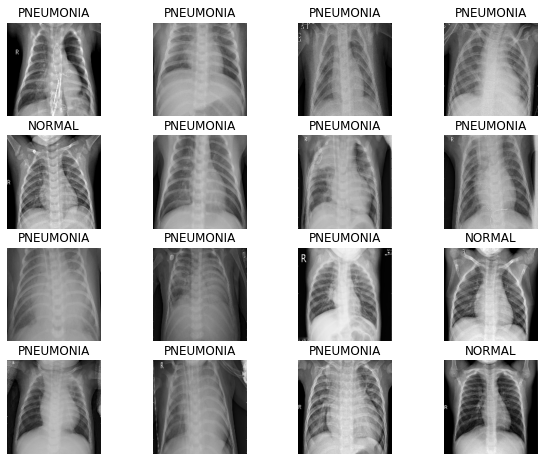

In [16]:
def show_batch(image_batch, label_batch):
    plt.figure(figsize=(10,10))
    for n in range(BATCH_SIZE):
        ax = plt.subplot(5,math.ceil(BATCH_SIZE/5),n+1)
        plt.imshow(image_batch[n])
        if label_batch[n]:
            plt.title("PNEUMONIA")
        else:
            plt.title("NORMAL")
        plt.axis("off")

#train에 있는 batch 중 첫 번째 배치를 추출해서 image와 label 데이터 셋으로 나눔.
image_batch, label_batch = next(iter(train_ds))
show_batch(image_batch.numpy(), label_batch.numpy())

## 모델링

### - CNN 모델링

In [17]:
def conv_block(filters):
    block = tf.keras.Sequential([
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPool2D()
    ])
    
    return block

- Convolution을 두 번 진행.
- Batch Normalization을 통해서 Gradient vanishing, Gradient Exploding을 해결 후 Max Pooling을 함.

In [18]:
def dense_block(units, dropout_rate):
    block = tf.keras.Sequential([
        tf.keras.layers.Dense(units, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(dropout_rate)
    ])
    
    return block

- Batch Normalization과 Dropout이라는 두 가지 regularization 기법이 동시에 사용.
- 일반적으로 이런 방법은 잘 사용되지 않거나, 금기시되기도 함.
-  variance shift를 억제하는 Batch Normalization과 이를 유발하는 Dropout을 동시에 사용하는 것이 어울리지 않기 때문이라고 함.
- 예외적으로 동시에 사용하는 것이 성능 향상에 도움을 주는 경우도 있으며 옹호하는 경우도 있음.
- 이번 실습에서 동시에 사용하는 이 모델이 성능 향상에 도움이 될지 보는 것이 하나의 포인트인 듯

In [19]:
def build_model():
    model = tf.keras.Sequential([
        tf.keras.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3)),
        
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.MaxPool2D(),
        
        conv_block(32),
        conv_block(64),
        
        conv_block(128),
        tf.keras.layers.Dropout(0.2),
        
        conv_block(256),
        tf.keras.layers.Dropout(0.2),
        
        tf.keras.layers.Flatten(),
        dense_block(512, 0.7),
        dense_block(128, 0.5),
        dense_block(64, 0.3),
        
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    
    return model

### - 데이터 불균형 처리
- 해결하는 방법으로 Weight balancing이라는 테크닉이 사용됨.
- Weight balancing 은 training set의 각 데이터에서 loss를 계산할 때 특정 클래스의 데이터에 더 큰 loss 값을 갖도록 가중치를 부여하는 방법임.
- Keras는 model.fit()을 호출할 때 파라미터로 넘기는 class_weight 에 이러한 클래스별 가중치를 세팅할 수 있도록 지원하고 있음.

In [20]:
#이 weight들은 'Normal'과 'Pneumonia' 전체 데이터 건수에 반비례하도록 설정됨.

#'Normal' 이미지에 사용할 weight
weight_for_0 = (1 / COUNT_NORMAL)*(TRAIN_IMG_COUNT)/2.0 

# 'Pneumonia' 이미지에 사용할 weight
weight_for_1 = (1 / COUNT_PNEUMONIA)*(TRAIN_IMG_COUNT)/2.0

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for NORMAL: {:.2f}'.format(weight_for_0))
print('Weight for PNEUMONIA: {:.2f}'.format(weight_for_1))

Weight for NORMAL: 1.91
Weight for PNEUMONIA: 0.68


### - 모델 훈련
- 이미지 훈련은 GPU를 사용할 것, tf.device('/GPU:0')으로 GPU를 선택해야 함.

In [21]:
with tf.device('/GPU:0'):
    model = build_model()

    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]  #성과 측정 위함
    
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',  #라벨이 두개 뿐이니까 binary_crossentropy 사용
        metrics=METRICS
    )

In [22]:
with tf.device('/GPU:0'):
    history = model.fit(
        train_ds,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=val_ds,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight,
    )

Epoch 1/25
261/261 [==============================] - 93s 251ms/step - loss: 0.4780 - accuracy: 0.7682 - precision: 0.9324 - recall: 0.7349 - val_loss: 0.6235 - val_accuracy: 0.7558 - val_precision: 0.7558 - val_recall: 1.0000
Epoch 2/25
261/261 [==============================] - 63s 243ms/step - loss: 0.2407 - accuracy: 0.9046 - precision: 0.9656 - recall: 0.9021 - val_loss: 1.3003 - val_accuracy: 0.7558 - val_precision: 0.7558 - val_recall: 1.0000
Epoch 3/25
261/261 [==============================] - 65s 248ms/step - loss: 0.1790 - accuracy: 0.9374 - precision: 0.9789 - recall: 0.9350 - val_loss: 0.3927 - val_accuracy: 0.8067 - val_precision: 0.7961 - val_recall: 1.0000
Epoch 4/25
261/261 [==============================] - 64s 246ms/step - loss: 0.1718 - accuracy: 0.9358 - precision: 0.9742 - recall: 0.9375 - val_loss: 0.5123 - val_accuracy: 0.8538 - val_precision: 0.9984 - val_recall: 0.8079
Epoch 5/25
261/261 [==============================] - 64s 245ms/step - loss: 0.1621 - accura

### - 결과 확인

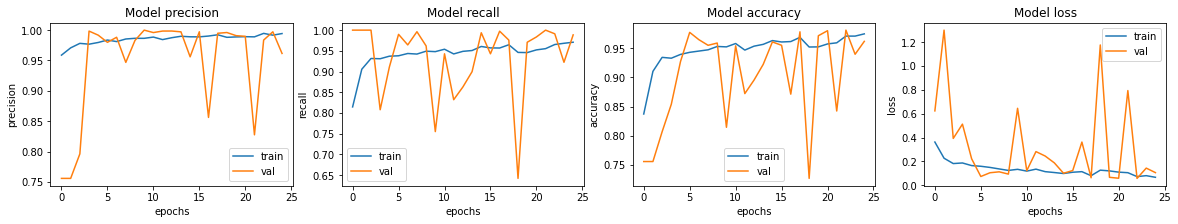

In [23]:
#그래프로 Epochs 마다 모델의 precision, recall, accuracy, loss가 어떻게 변하는지 시각화

fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

### - 모델 평가
- 테스트 데이터로 모델 평가

In [24]:
loss, accuracy, precision, recall = model.evaluate(test_ds)
print(f'Loss: {loss},\nAccuracy: {accuracy},\nPrecision: {precision},\nRecall: {recall}')

39/39 [==============================] - 5s 98ms/step - loss: 1.5203 - accuracy: 0.6971 - precision: 0.6754 - recall: 0.9923
Loss: 1.5202572345733643,
Accuracy: 0.6971153616905212,
Precision: 0.6753926873207092,
Recall: 0.9923076629638672
